In [162]:
from __future__ import division
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
with open('datapath.txt', 'r') as f:
    datapath = f.readlines()[0].strip()

In [6]:
foster_care_path = 'CYF Active 2010 to 2016-11-09(1).csv'

In [8]:
foster_care = pd.read_csv(datapath + foster_care_path)

In [11]:
homeless_path = 'HomelessShelters(1).csv'

In [97]:
homeless = pd.read_csv(datapath + homeless_path)

Drop CL_ID, should be redundent. Maybe could help merge with other datasets?

In [21]:
foster_care.drop('CL_ID', axis=1, inplace=True)

A bunch of the MCI_ID are zero. This seems to be a wastebasket MCI id

In [34]:
foster_care[foster_care['MCI_ID'] == 0].shape

(6859, 8)

In [69]:
foster_care = foster_care[foster_care['MCI_ID'] > 0.0]

Data dictionary says "Ignore IDs that are less than 10 digits -- those are source system and you will not be able to link". I'm just dropping them

In [98]:
homeless = homeless[homeless['MCI_ID_OR_HMIS_CLIENT_ID'] >= 1e9]

In [49]:
unique_homeless_mci = homeless['MCI_ID_OR_HMIS_CLIENT_ID'].unique()

In [40]:
unique_foster_mci = foster_care['MCI_ID'].unique()

In [50]:
sum([i in unique_foster_mci for i in unique_homeless_mci])

4312

In [125]:
cyf_groupby = foster_care.groupby('MCI_ID')

In [166]:
plt.hist?

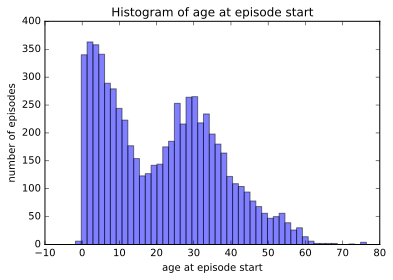

In [171]:
plt.hist(age_values, bins=50, alpha=0.5)
plt.xlabel('age at episode start')
plt.ylabel('number of episodes')
plt.title('Histogram of age at start of homelessness episode')
plt.
plt.show()



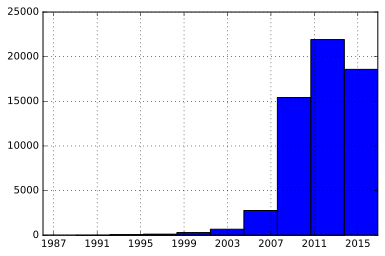

In [147]:
pd.to_datetime(foster_care['INVLV_STRT_DT'], errors='coerce').hist()

In [143]:
foster_care.columns

Index([u'CAS_ID', u'MCI_ID', u'BRTH_DT', u'AGE', u'GENDER', u'RACE',
       u'INVLV_STRT_DT', u'INVLV_END_DT'],
      dtype='object')

In [ ]:
pd.to_

In [142]:
pd.to_datetime(foster_care[''], errors='coerce').min()

Timestamp('1776-01-01 00:00:00')

In [141]:
homeless['PROJ_INVOLVEMENT_EPISODE_START'].min()

Timestamp('2001-07-01 00:00:00')

In [ ]:
homeless

In [150]:
age_at_episode_start = ((pd.to_datetime(homeless['PROJ_INVOLVEMENT_EPISODE_START'], errors='coerce')
                         - pd.to_datetime(homeless['BRTH_DT'], errors='coerce')).dt.days / 365)

In [153]:
age_at_episode_start.hist?

In [160]:
age_values = age_at_episode_start.dropna().values

In [161]:
age_values

array([ 15.64383562,  14.75616438,  36.3369863 , ...,   3.35616438,
        41.70684932,  10.68219178])

In [132]:
pd.to_datetime(foster_care['INVLV_END_DT'], errors='coerce')

1       2012-01-09
3              NaT
4              NaT
5       2011-08-31
10      2011-08-31
11      2011-08-31
12      2011-08-31
13      2011-06-20
14      2014-03-18
15      2011-06-20
17      2014-03-18
18      2011-06-20
21      2011-06-20
22      2014-03-18
23      2014-03-18
24      2010-07-01
25      2010-07-01
26      2010-07-07
27      2010-07-01
28      2015-01-07
36      2015-01-07
37             NaT
38      2013-05-14
39      2014-12-29
40      2014-12-29
41      2013-06-19
42             NaT
43             NaT
44             NaT
45      2015-10-22
           ...    
66757          NaT
66758          NaT
66759          NaT
66760          NaT
66761          NaT
66762          NaT
66763          NaT
66764          NaT
66765          NaT
66766          NaT
66767          NaT
66768          NaT
66769          NaT
66770          NaT
66771          NaT
66772          NaT
66773          NaT
66774          NaT
66775          NaT
66776          NaT
66777          NaT
66778       

In [129]:
(cyf_groupby['INVLV_STRT_DT'].count()>1).sum()

3556

In [80]:
demo_lookup = pd.DataFrame([foster_care.groupby('MCI_ID')[i].unique().map(lambda x: x[0])
                            for i in demographic_col], index=demographic_col).T

In [130]:
demo_lookup['N_CYF_CASES'] = cyf_groupby['INVLV_STRT_DT'].count()

In [ ]:
def date_diff(s):
    pd.to_datetime(s['INVLV_END_DT']) - pd.to_datetime(s)

In [ ]:
demo_lookup['']

In [83]:
demo_lookup.shape

(55857, 3)

In [88]:
homeless.columns

Index([u'MCI_ID_OR_HMIS_CLIENT_ID', u'FIRST_INVOLVEMENT_IN_EPISODE',
       u'LAST_INVOLVEMENT_IN_EPISODE', u'PROJ_INVOLVEMENT_EPISODE_START',
       u'PROJ_INVOLVEMENT_EPISODE_END', u'DURATION_OF_STAY',
       u'HUD_PROJECT_TYPE'],
      dtype='object')

In [99]:
homeless = homeless.join(demo_lookup, on='MCI_ID_OR_HMIS_CLIENT_ID', how='left')

In [106]:
homeless[~homeless[demographic_col[0]].isnull()]['MCI_ID_OR_HMIS_CLIENT_ID'].nunique() / homeless['MCI_ID_OR_HMIS_CLIENT_ID'].nunique()

0.20784729586426298

In [117]:
pd.to_datetime?

In [ ]:
homeless.loc[845, 'PROJ_INVOLVEMENT_EPISODE_START']

In [121]:
homeless.head()

,MCI_ID_OR_HMIS_CLIENT_ID,FIRST_INVOLVEMENT_IN_EPISODE,LAST_INVOLVEMENT_IN_EPISODE,PROJ_INVOLVEMENT_EPISODE_START,PROJ_INVOLVEMENT_EPISODE_END,DURATION_OF_STAY,HUD_PROJECT_TYPE,BRTH_DT,GENDER,RACE
0,1000119566,33948.0,33948.0,7/12/2016,7/12/2016,1.0,CYF Rental Assist,11/23/2000,Female,Black or African American
1,1000049489,20863.0,20863.0,2/9/2015,2/9/2105,32872.0,CYF Rental Assist,5/12/2000,Male,Black or African American
2,1000734411,32442.0,32442.0,5/18/2016,8/16/2019,1185.0,Homelessness Prevention,NaN,NaN,NaN
3,1000285813,36843.0,36843.0,10/24/2016,11/29/2016,36.0,Emergency Shelter,7/2/1980,Male,White
4,1000854631,34479.0,34479.0,11/15/2016,11/16/2016,1.0,Emergency Shelter,NaN,NaN,NaN


In [123]:
homeless['PROJ_INVOLVEMENT_EPISODE_START'] = pd.to_datetime(homeless['PROJ_INVOLVEMENT_EPISODE_START'], errors='coerce')

In [124]:
homeless['PROJ_INVOLVEMENT_EPISODE_END'] = pd.to_datetime(homeless['PROJ_INVOLVEMENT_EPISODE_END'], errors='coerce')

In [109]:
homeless.groupby('GENDER').describe()

DURATION_OF_STAY  FIRST_INVOLVEMENT_IN_EPISODE  \
GENDER                                                         
Female count       4155.000000                   4155.000000   
       mean         205.147292                  20479.645247   
       std          399.002961                  11213.976504   
       min            1.000000                     31.000000   
       25%            1.000000                  10697.500000   
       50%           33.000000                  22917.000000   
       75%          209.000000                  29985.500000   
       max         4210.000000                  37177.000000   
Male   count       2421.000000                   2421.000000   
       mean         772.749277                  20192.848410   
       std        19978.090680                  11152.007972   
       min            1.000000                     10.000000   
       25%            1.000000                   9999.000000   
       50%           31.000000                  22021.000000   
       75%          182.000000                  29896.000000   
       max       730488.000000                  37164.000000   

              LAST_INVOLVEMENT_IN_EPISODE  MCI_ID_OR_HMIS_CLIENT_ID  
GENDER                                                               
Female count                  4155.000000              4.155000e+03  
       mean                  20598.375211              1.000452e+09  
       std                   11152.325903              2.332039e+05  
       min                      31.000000              1.000000e+09  
       25%                   11021.500000              1.000283e+09  
       50%                   23031.000000              1.000401e+09  
       75%                   30046.000000              1.000675e+09  
       max                   37177.000000              1.000858e+09  
Male   count                  2421.000000              2.421000e+03  
       mean                  20317.122677              1.000512e+09  
       std                   11078.100545              2.336530e+05  
       min                      10.000000              1.000001e+09  
       25%                   10540.000000              1.000322e+09  
       50%                   22252.000000              1.000554e+09  
       75%                   29932.000000              1.000721e+09  
       max                   37164.000000              1.000858e+09

In [107]:
homeless[~homeless[demographic_col[0]].isnull()]['MCI_ID_OR_HMIS_CLIENT_ID'].nunique()

4312

In [108]:
homeless['MCI_ID_OR_HMIS_CLIENT_ID'].nunique()

20746

In [103]:
homeless.shape

(30305, 10)

In [100]:
homeless.dropna().shape

(5640, 10)

In [81]:
(demo_lookup.applymap(lambda x: len(x)) != 1).sum()

TypeError: ("object of type 'float' has no len()", u'occurred at index RACE')

In [ ]:
foster_care[foster_care]

In [52]:
foster_care.columns

Index([u'CAS_ID', u'MCI_ID', u'BRTH_DT', u'AGE', u'GENDER', u'RACE',
       u'INVLV_STRT_DT', u'INVLV_END_DT'],
      dtype='object')

In [71]:
demographic_col = [u'BRTH_DT', u'GENDER', u'RACE']

In [68]:
unique_demo = pd.DataFrame([foster_care.groupby('MCI_ID')[i].nunique()
                            for i
                            in demographic_col], index=demographic_col).T

In [ ]:
foster_care.groupby('MCI_ID').

In [67]:
(unique_demo > 1).sum()

BRTH_DT       1
GENDER        1
RACE          1
CAS_ID     2881
dtype: int64

In [37]:
Out[36].shape

(55858, 8)

In [36]:
foster_care.groupby('MCI_ID').apply(lambda x: x.iloc[0])

,CAS_ID,MCI_ID,BRTH_DT,AGE,GENDER,RACE,INVLV_STRT_DT,INVLV_END_DT
MCI_ID,,,,,,,,
0.000000e+00,42753,0.000000e+00,NaN,NaN,Male,NaN,5/9/2009,4/26/2012
1.000000e+09,72876,1.000000e+09,10/28/1982,34.0,Male,White,9/14/2016,NaN
1.000000e+09,71879,1.000000e+09,1/17/1981,35.0,Male,Black or African American,12/5/2015,2/3/2016
1.000000e+09,46464,1.000000e+09,8/29/1965,51.0,Male,White,10/7/2010,1/21/2015
1.000000e+09,62237,1.000000e+09,10/18/1971,45.0,Male,White,6/1/2011,10/2/2012
1.000000e+09,41724,1.000000e+09,12/21/1985,30.0,Male,Black or African American,10/1/2008,4/17/2014
1.000000e+09,42154,1.000000e+09,10/1/1980,36.0,Male,Black or African American,1/18/2005,NaN
1.000000e+09,40922,1.000000e+09,11/3/1975,41.0,Male,Black or African American,5/31/2011,NaN
1.000000e+09,69680,1.000000e+09,11/28/1997,18.0,Male,Black or African American,10/2/2014,1/8/2016


In [28]:
(foster_care.groupby('MCI_ID')['GENDER'].nunique() != 1)

MCI_ID
0.000000e+00     True
1.000000e+09    False
1.000000e+09    False
1.000000e+09    False
1.000000e+09    False
1.000000e+09    False
1.000000e+09    False
1.000000e+09    False
1.000000e+09    False
1.000000e+09    False
1.000000e+09    False
1.000000e+09    False
1.000000e+09    False
1.000001e+09    False
1.000001e+09    False
1.000001e+09    False
1.000001e+09    False
1.000001e+09    False
1.000001e+09    False
1.000001e+09    False
1.000001e+09    False
1.000001e+09    False
1.000001e+09    False
1.000001e+09    False
1.000001e+09    False
1.000001e+09    False
1.000001e+09    False
1.000001e+09    False
1.000001e+09    False
1.000001e+09    False
                ...  
1.000864e+09    False
1.000864e+09    False
1.000864e+09    False
1.000864e+09    False
1.000864e+09    False
1.000864e+09    False
1.000864e+09    False
1.000864e+09    False
1.000864e+09    False
1.000864e+09    False
1.000864e+09    False
1.000864e+09    False
1.000864e+09    False
1.000864e+09    False
1.0